In [1]:
using ITensors, ITensorMPS, PythonPlot

# Reset global variables
global psi = []
global energies = []
global overlap_matrix = nothing
global ground_state_labels = []
global excited_state_label = nothing

# Length of the spin chain
global L = 30 

# Create L Spin-1/2 Indices
global sites = siteinds("S=1/2", L)

let
    # Create the Hamiltonian (HI) of the Ising chain at its self-dual critical point from the O'Brien and Fendley paper.
    osI = OpSum()
    for j in 1:(L - 1)
        osI -= "X", j 
        osI -= "Z", j, "Z", j + 1
    end
        # Boundary terms
        osI -= "X", L
        osI -= "Z", L, "Z", 1
        HI = MPO(osI, sites)

    # Create the Hamiltonian (H3) of the three-spin interaction from the O'Brien and Fendley paper.
    os3 = OpSum()
    for j in 1:(L - 2)
        os3 += "X", j, "Z", j + 1, "Z", j + 2
        os3 += "Z", j, "Z", j + 1, "X", j + 2
    end
        # Boundary terms
        os3 += "X", L - 1, "Z", L, "Z", 1
        os3 += "X", L, "Z", 1, "Z", 2
        os3 += "Z", L - 1, "Z", L, "X", 1
        os3 += "Z", L, "Z", 1, "X", 2
        H3 = MPO(os3, sites)

    # Coupling coefficients for Exact G.S.
        lambdaI = 1
        lambda3 = 1

    # Adding energy offset E0 to the first site
    EO = L * (lambdaI^2 + lambda3^2) / lambda3
    osEO = OpSum()
        osEO += EO, "Id", 1
    E0 = MPO(osEO, sites)

    # Full Hamiltonian from paper
    H = 2 * lambdaI * HI + lambda3 * H3 + E0

    # Create an initial random matrix product state
    psi0 = random_mps(sites)
    
    # Set the number of sweeps, bond dimensions, and cutoff for the DMRG algorithm
    nsweeps = 20
    maxdim = [10, 33, 66, 133, 200]
    mindim = maxdim
    cutoff = 1.0e-10

    println("Maxdim per sweep: ", maxdim)
    println()
    
    # Run DMRG to find 3 ground states and 1 excited state
    global psi = Vector{MPS}(undef, 4)
    global energies = zeros(4)

    # Find a ground state
    println("Finding first ground state:")
    observer1 = DMRGObserver(; energy_tol=1e-8)
    energies[1], psi[1] = dmrg(H, psi0; nsweeps, mindim, maxdim, cutoff, observer=observer1)
    println("Final energy for ground state 1: $(energies[1])")
    println()

    # Find subsequent states while forcing orthogonality
    for i in 2:4
        state_name = i <= 3 ? "Ground state $i" : "Excited state"
        println("Finding $state_name:")
        observer = DMRGObserver(; energy_tol=1e-8)
        energies[i], psi[i] = dmrg(H, psi[1:(i-1)], psi0; nsweeps, mindim, maxdim, cutoff, weight=100, observer=observer)
        println("Final energy for $state_name: $(energies[i])")
        println()
    end

    # Sort and label the states
    sorted_indices = sortperm(energies)
    ground_state_indices = sorted_indices[1:3]
    excited_state_index = sorted_indices[4]

    println("Energy results from DMRG:")
    for (i, idx) in enumerate(sorted_indices)
        if i <= 3
            println("Ground state $i = $(energies[idx]) (state $idx)")
        else
            println("Excited state = $(energies[idx]) (state $idx)")
        end
    end
    
    # Analysis of overlap between the 4 states
    function analyze_overlaps(psi, ground_state_indices, excited_state_index)
        n_ground = length(ground_state_indices)

        # Create an overlap matrix
        all_indices = [ground_state_indices..., excited_state_index]
        n_total = length(all_indices)
        overlap_matrix = zeros(ComplexF64, n_total, n_total)

        # Compute the overlaps
        for (i, idx_i) in enumerate(all_indices)
            for (j, idx_j) in enumerate(all_indices)
                overlap_matrix[i, j] = inner(psi[idx_i], psi[idx_j])
            end
        end

        # Check normalizations
        println("\nNormalizations:")
        for (i, idx) in enumerate(all_indices)
            norm_val = abs(overlap_matrix[i,i])
            state_type = i <= n_ground ? "Ground state $i" : "Excited state"
            println("$state_type: ⟨ψ$idx|ψ$idx⟩ = $(round(norm_val, digits=10))")
        end

        # Ground state orthogonality
        println("\nGround State Overlaps:")
        for i in 1:n_ground
            for j in (i+1):n_ground
                overlap_val = abs(overlap_matrix[i,j])
                println("⟨ψ$(all_indices[i])|ψ$(all_indices[j])⟩ = $overlap_val")
            end
        end

        # Ground-excited orthogonality
        println("\nGround-Excited Overlaps:")
        for i in 1:n_ground
            overlap_val = abs(overlap_matrix[i, end])
            println("⟨ψ$(all_indices[i])|ψ$(all_indices[end])⟩ = $overlap_val")
        end

        return overlap_matrix
    end

    global overlap_matrix = analyze_overlaps(psi, ground_state_indices, excited_state_index)
    global ground_state_labels = ground_state_indices
    global excited_state_label = excited_state_index

    nothing
end

Maxdim per sweep: [10, 33, 66, 133, 200]

Finding first ground state:
After sweep 1 energy=3.046021528484795  maxlinkdim=4 maxerr=2.49E-16 time=11.006
After sweep 2 energy=0.019773968912927993  maxlinkdim=16 maxerr=3.36E-16 time=0.064
After sweep 3 energy=0.00010934702433817379  maxlinkdim=64 maxerr=5.32E-16 time=0.444
After sweep 4 energy=8.429245621499604e-7  maxlinkdim=133 maxerr=1.73E-14 time=3.545
After sweep 5 energy=5.818845703316107e-9  maxlinkdim=200 maxerr=1.16E-15 time=7.788
After sweep 6 energy=2.8829474567460045e-11  maxlinkdim=200 maxerr=5.83E-16 time=9.036
Energy difference less than 1.0e-8, stopping DMRG
Final energy for ground state 1: 2.8829474567460045e-11

Finding Ground state 2:
After sweep 1 energy=3.188580546785568  maxlinkdim=4 maxerr=1.67E-16 time=0.523
After sweep 2 energy=1.3130129496556393  maxlinkdim=16 maxerr=3.98E-16 time=0.129
After sweep 3 energy=1.229981948134743  maxlinkdim=64 maxerr=1.02E-15 time=0.924
After sweep 4 energy=0.000276859042866642  maxli

Max and Min Correlations for Ground States:
State 1: max = 0.0, min = 0.0
State 3: max = 1.0, min = 1.0
State 2: max = 1.0, min = 1.0

Max and Min Correlations for Excited State:
State 4: max = 0.519, min = 0.205


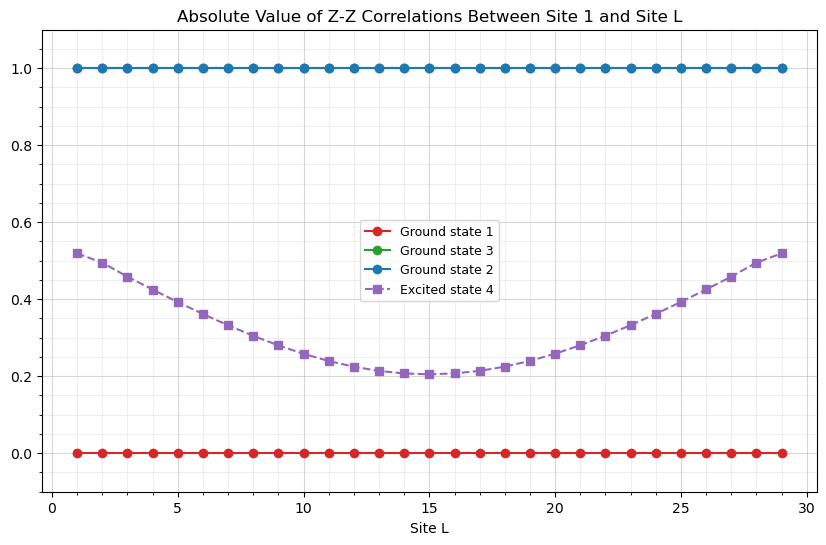

In [8]:
using PythonPlot

# Compute Z-Z correlations matrices for all states
C1zz = correlation_matrix(psi[ground_state_labels[1]], "Z", "Z")
C2zz = correlation_matrix(psi[ground_state_labels[2]], "Z", "Z")
C3zz = correlation_matrix(psi[ground_state_labels[3]], "Z", "Z")
C4zz = correlation_matrix(psi[excited_state_label], "Z", "Z")

# Get the absolute values of correlations
abs_C1zz = abs.(C1zz[1, 2:end])
abs_C2zz = abs.(C2zz[1, 2:end])
abs_C3zz = abs.(C3zz[1, 2:end])
abs_C4zz = abs.(C4zz[1, 2:end]) # Excited state

figure(figsize=(10, 6))

# Plot the Z-Z correlations for ground states
x1 = collect(1:length(abs_C1zz))
plot(x1, abs_C1zz, marker="o", linestyle="-", color="tab:red", linewidth=1.5, 
     label="Ground state $(ground_state_labels[1])")
x2 = collect(1:length(abs_C2zz))
plot(x2, abs_C2zz, marker="o", linestyle="-", color="tab:green", linewidth=1.5,
     label="Ground state $(ground_state_labels[2])")
x3 = collect(1:length(abs_C3zz))
plot(x3, abs_C3zz, marker="o", linestyle="-", color="tab:blue", linewidth=1.5,
     label="Ground state $(ground_state_labels[3])")

# Plot the Z-Z correlations for excited state
x4 = collect(1:length(abs_C4zz))
plot(x4, abs_C4zz, marker="s", linestyle="--", color="tab:purple", linewidth=1.5,
     label="Excited state $(excited_state_label)")

legend(fontsize=9)
xlabel("Site L")
title("Absolute Value of Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
    
# Adjust graph for Z-Z correlations
ymax = max(maximum(abs_C1zz), maximum(abs_C2zz), maximum(abs_C3zz), maximum(abs_C4zz))
ymin = min(minimum(abs_C1zz), minimum(abs_C2zz), minimum(abs_C3zz), minimum(abs_C4zz))
ylim(ymin - 0.1, ymax + 0.1)
minorticks_on()
    
# Print max and min values for reference
println("Max and Min Correlations for Ground States:")
println("State $(ground_state_labels[1]): max = $(round(maximum(abs_C1zz), digits=4)), min = $(round(minimum(abs_C1zz), digits=4))")
println("State $(ground_state_labels[2]): max = $(round(maximum(abs_C2zz), digits=4)), min = $(round(minimum(abs_C2zz), digits=4))")
println("State $(ground_state_labels[3]): max = $(round(maximum(abs_C3zz), digits=4)), min = $(round(minimum(abs_C3zz), digits=4))")
println("\nMax and Min Correlations for Excited State:")
println("State $(excited_state_label): max = $(round(maximum(abs_C4zz), digits=4)), min = $(round(minimum(abs_C4zz), digits=4))")

Max and Min Correlations for Ground States:
State 1: max = 1.0, min = 1.0
State 3: max = 0.0, min = 0.0
State 2: max = 0.0, min = 0.0

Max and Min Correlations for Excited State:
State 4: max = 0.5649, min = 0.2537


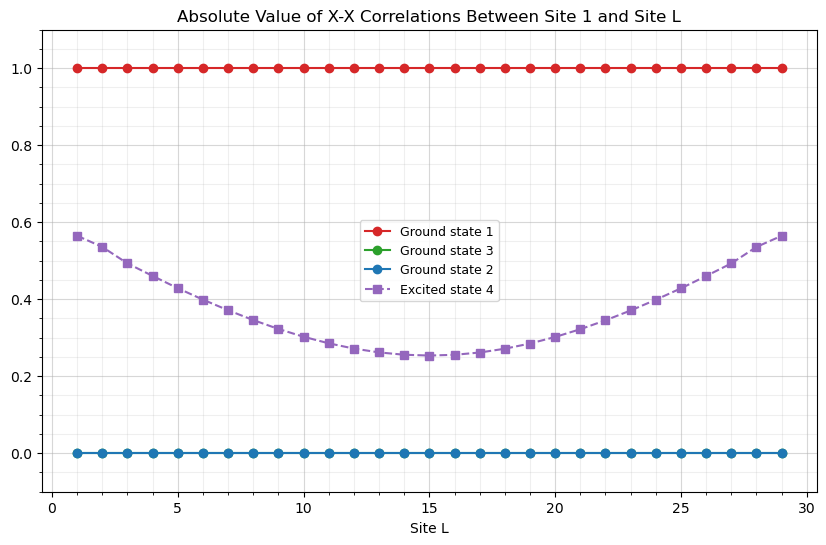

In [9]:
using PythonPlot

# Calculate X-X correlation matrices for all states
C1xx = correlation_matrix(psi[ground_state_labels[1]], "X", "X")
C2xx = correlation_matrix(psi[ground_state_labels[2]], "X", "X")
C3xx = correlation_matrix(psi[ground_state_labels[3]], "X", "X")
C4xx = correlation_matrix(psi[excited_state_label], "X", "X")

# Get the absolute values of X-X correlations
abs_C1xx = abs.(C1xx[1, 2:end])
abs_C2xx = abs.(C2xx[1, 2:end])
abs_C3xx = abs.(C3xx[1, 2:end])
abs_C4xx = abs.(C4xx[1, 2:end]) # Excited state

figure(figsize=(10, 6))

# Plot the X-X correlations for ground states
x1 = collect(1:length(abs_C1xx))
plot(x1, abs_C1xx, marker="o", linestyle="-", color="tab:red", linewidth=1.5, 
     label="Ground state $(ground_state_labels[1])")
x2 = collect(1:length(abs_C2xx))
plot(x2, abs_C2xx, marker="o", linestyle="-", color="tab:green", linewidth=1.5,
     label="Ground state $(ground_state_labels[2])")
x3 = collect(1:length(abs_C3xx))
plot(x3, abs_C3xx, marker="o", linestyle="-", color="tab:blue", linewidth=1.5,
     label="Ground state $(ground_state_labels[3])")

# Plot the Z-Z correlations for excited state
x4 = collect(1:length(abs_C4xx))
plot(x4, abs_C4xx, marker="s", linestyle="--", color="tab:purple", linewidth=1.5,
     label="Excited state $(excited_state_label)")

legend(fontsize=9)
xlabel("Site L")
title("Absolute Value of X-X Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)

# Adjust graph for X-X correlations
ymax = max(maximum(abs_C1xx), maximum(abs_C2xx), maximum(abs_C3xx), maximum(abs_C4xx))
ymin = min(minimum(abs_C1xx), minimum(abs_C2xx), minimum(abs_C3xx), minimum(abs_C4xx))
ylim(ymin - 0.1, ymax + 0.1)
minorticks_on()

# Print max and min values for reference
println("Max and Min Correlations for Ground States:")
println("State $(ground_state_labels[1]): max = $(round(maximum(abs_C1xx), digits=4)), min = $(round(minimum(abs_C1xx), digits=4))")
println("State $(ground_state_labels[2]): max = $(round(maximum(abs_C2xx), digits=4)), min = $(round(minimum(abs_C2xx), digits=4))")
println("State $(ground_state_labels[3]): max = $(round(maximum(abs_C3xx), digits=4)), min = $(round(minimum(abs_C3xx), digits=4))")
println("\nMax and Min Correlations for Excited State:")
println("State $(excited_state_label): max = $(round(maximum(abs_C4xx), digits=4)), min = $(round(minimum(abs_C4xx), digits=4))")